In [12]:
# Import required libraries
from math import sqrt
from scipy.stats import norm
from statistics import variance
import statsmodels.api as sm
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [13]:
# Connect Google Drive to read csv file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Load csv data file in Google Drive
csv_file_path = "/content/drive/My Drive/HNB_Data.csv"
# Load the CSV file into a Pandas DataFrame
data = pd.read_csv(csv_file_path)

#Print Data frame
print(data.head())

       Date   Price  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0  7/5/2021  100.55         NaN         NaN         NaN         NaN   
1  7/6/2021   99.16         NaN         NaN         NaN         NaN   
2  7/7/2021   98.00         NaN         NaN         NaN         NaN   
3  7/8/2021   99.39         NaN         NaN         NaN         NaN   
4  7/9/2021  102.18         NaN         NaN         NaN         NaN   

   Unnamed: 6  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  


In [15]:
# Remove unnecessary columns
data = data[['Date', 'Price']]
data.head()

,Date,Price
0,7/5/2021,100.55
1,7/6/2021,99.16
2,7/7/2021,98.00
3,7/8/2021,99.39
4,7/9/2021,102.18


In [16]:
# Create time_index
rows = data.shape[0]
time_index = list(range(0,rows))

In [17]:
# Calculate log returns
log_returns = np.zeros(rows)

for i in range(1,rows):
  log_returns[i] = np.log(data.iloc[i,1]) - np.log(data.iloc[i-1,1])

data['log_returns'] = log_returns
data.head()

,Date,Price,log_returns
0,7/5/2021,100.55,0.000000
1,7/6/2021,99.16,-0.013920
2,7/7/2021,98.00,-0.011767
3,7/8/2021,99.39,0.014084
4,7/9/2021,102.18,0.027684


In [18]:
log_returns_mean= np.mean(log_returns)
print("Log Returns Mean:", log_returns_mean)

Log Returns Mean: 0.0008810985894420429


In [19]:
log_returns_variance = np.var(log_returns)
print("Log Returns Variance:", log_returns_variance)

Log Returns Variance: 0.0008023137261862619


In [20]:
mu_hat = log_returns_mean + (log_returns_variance)/2
print("Estimated drift parameter:", mu_hat)

Estimated drift parameter: 0.0012822554525351738


In [21]:
sigma_hat = np.sqrt(log_returns_variance)
print("Estimated scale parameter:", sigma_hat)

Estimated scale parameter: 0.028325143003809564


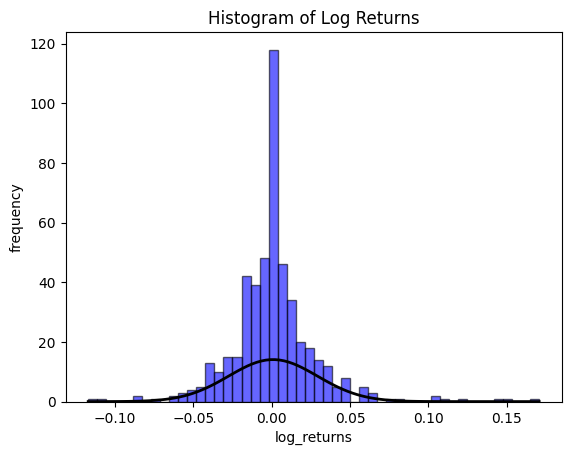

In [22]:
plt.hist(data['log_returns'], bins=50,density=False,alpha=0.6,color='b', edgecolor='black')
mu, std = norm.fit(log_returns)
x = np.linspace(min(log_returns), max(log_returns), 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2, label=f'Fitted Normal Curve ($\mu={mu:.2f}$, $\sigma={std:.2f}$)')
plt.xlabel('log_returns')
plt.ylabel('frequency')
plt.title('Histogram of Log Returns')
plt.show()

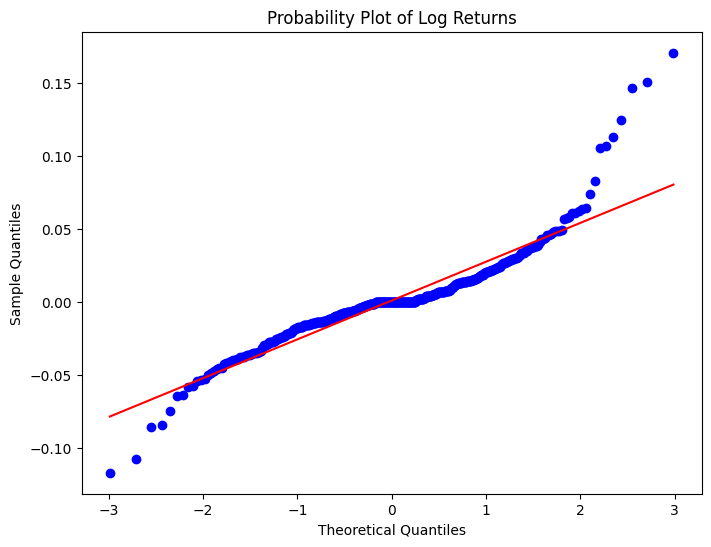

In [23]:
# Create a probability plot (Q-Q plot) for the log returns
plt.figure(figsize=(8, 6))
stats.probplot(data['log_returns'], dist="norm", plot=plt)
plt.title("Probability Plot of Log Returns")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

In [24]:
#check the normality of the log returns data
from scipy.stats import shapiro
stat, p = shapiro(log_returns)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Check whether it is appropriate to model the closing price of HNB using geometric Brownian motion.
alpha = 0.05
if p > alpha:
 print('Appropriate to model using geometric Brownian motion')
 #sample looks Gaussian(null hypothesis (H0) is fail to rejected)
else:
 print('Not appropriate to model using geometric Brownian motion')
 #sample does not look Gaussian(null hypothesis (H0) is rejected)

Statistics=0.876, p=0.000
Not appropriate to model using geometric Brownian motion


In [25]:
def BrownianG (m, T, N, sigma, mu, w0, GB=False):
  '''
  Arguments
  ---------
  m- Number of sample paths
  T - Total time
  sigma - Scale paramter
  N - Number of steps
  mu - Drift Paramter
  w0 - Statrting value

  ##Returns
  -------
  numpy array with shape(m,N+1),where the first column gives the
  initial values of each path
  '''

  # time step
  dt = T/N
  # creating an array to store values (m,N+1)
  x = np.zeros((m, N+1))
  # initial values of X
  x[:,0] = w0
  #creating an array to store simulated values
  x0 = x[:,0]

  alpha = mu - (sigma**2)/2
  #for each element of x0, generate sample of n number of elements from normal distribution
  r = stats.norm.rvs(size = x0.shape + (N,), loc = alpha*dt, scale = sigma*np.sqrt(dt), random_state=42)
  #computes brownian motion by taking cumulative sum of random samples
  np.cumsum(r, axis=-1, out=x[:,1:])

  if not GB: #use normal brownian motion
    #adding initial value
    x[:,1:]+=w0

  else: #use geometric brownian motion
    if (w0!=0):
      x[:,1:]=w0*np.exp(x[:,1:])
    else:
      x[:,1:]=np.exp(x[:,1:])

  return x

In [26]:
w0 = data.iloc[rows-1,1]
N = 500

In [27]:
x=BrownianG(1000,20,150,sigma_hat,mu_hat,155.25,GB=True)
x

array([[155.25      , 156.06797592, 155.86325997, ..., 137.85868559,
        138.62119564, 139.06398603],
       [155.25      , 155.67103303, 156.24820024, ..., 173.81861841,
        175.30672388, 176.47280812],
       [155.25      , 153.94263066, 153.07126534, ..., 174.86069334,
        173.95423283, 172.07912439],
       ...,
       [155.25      , 154.05915407, 152.59325335, ..., 140.28446162,
        140.29190438, 140.5328748 ],
       [155.25      , 159.66699327, 156.41652138, ..., 164.78019026,
        163.39305383, 162.56650765],
       [155.25      , 156.140403  , 153.9246942 , ..., 207.888447  ,
        208.239104  , 209.92415984]])

In [28]:
def BrownianPlot(y,T):
    '''
    Arguments
    ---------
    y- array with shape (m,N+1). Each row gives discritized version
    of a sample path. There are m sample paths.
    T - Total time

    Returns
    -------
    A graph of all sample paths
    '''

 #Number of steps
    N = y.shape[1]
 #Length of time step
    dt = T/(N-1)

    t = np.linspace(0.0, N*dt, N)
    for k in range(y.shape[0]):
        plt.plot(t, y[k])
    plt.title('1000 Sample Paths')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Predicted Closing Price',fontsize=12)
    plt.grid(True)
    plt.show()

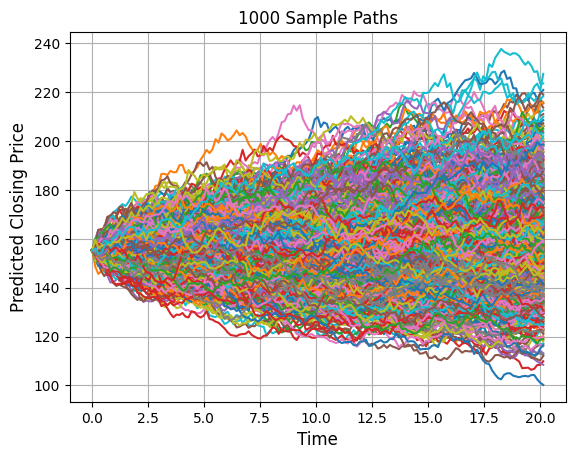

In [29]:
BrownianPlot(x,20)

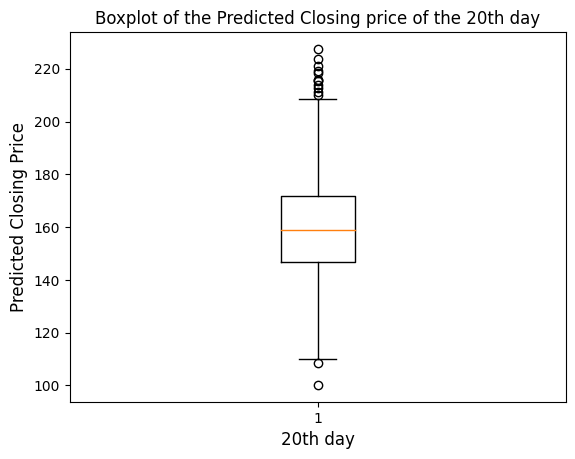

In [30]:
end_values = x[:,-1]
plt.boxplot(end_values)
plt.title("Boxplot of the Predicted Closing price of the 20th day")
plt.xlabel("20th day",fontsize=12)
plt.ylabel("Predicted Closing Price",fontsize=12)
plt.show()

In [31]:
#Now we can get probabilities for ending values
len(end_values[(end_values>160)& (end_values<175)])/len(end_values)

0.257

In [32]:
#95% prediction interval for endingValues
np.percentile(end_values,[2.5,97.5])

array([123.20027237, 200.33003057])